In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import re
from datetime import date, timedelta

In [61]:
class Population:
    def __init__(self, pop_size, name=""):
        self.name=name
        self.pop_size=pop_size
        self.pop_immunity={}
        self.health_data={}
        self.setImmunity()
    def setImmunity(self, *immunity_tuples):
        ##Pass tuples of (Name, Fraction of Population, Immunity Percentage) 
        for category in immunity_tuples:
            if len(category)!=3:
                raise RuntimeError("Expected well-formated triplets of (Name, Fraction of Population, Immunity Percentage)")
            self.pop_immunity[category[0]]=(category[1],category[2])
        frac_accounted=0
        for share in self.pop_immunity.values():
            frac_accounted+=share[1]
        if frac_accounted>1:
            raise RuntimeError("More than 100% of population newly assigned to an immunity category")
        elif frac_accounted!=1:
            self.pop_immunity["Naive"]=(1-frac_accounted,0)
    def setHealthData(self, data):
        self.health_data=data
    def getInfectionData(self, date1=None, date2=None):
        initial_date=date1 if date1!=None else min(self.health_data.keys())
        end_date=date2 if date2!=None else max(self.health_data.keys())
        increment_day=timedelta(days=1)
        case_data=[]
        current_day=initial_date
        while current_day<=end_date:
            case_data.append(self.health_data.get(current_day).get("cases") if self.health_data.get(current_day)!=None else None)
            current_day+=increment_day
        return case_data
    def getHealthData(self, d):
       
        search_d=d
        most_recent_data=None
        increment_day=timedelta(days=1)
        
        while most_recent_data==None:
            if search_d<min(self.health_data.keys()):
                return None
            most_recent_data=self.health_data.get(search_d)
            search_d-=increment_day
        return most_recent_data
    def getNewShots(self, d1, d2):
        initial_health_data=self.getHealthData(d1)
        if self.health_data.get(d2)==None:
            return 0, 0
        if initial_health_data==None:
            initial_health_data["vaccinated"]=0
            initial_health_data["boosted"]=0
        new_vax=self.health_data.get(d2).get("vaccinated")-initial_health_data.get("vaccinated")
        new_boost=self.health_data.get(d2).get("boosted")-initial_health_data.get("boosted")
        return new_vax, new_boost
##Models
class Model:
    def __init__(self, population):
        self.population=population
        self.t=0
        self.t_history=[]
    def runInfectionSimulation(self, duration, resolution, starting_infected):
        self.setInfected(starting_infected)
        decimals=round(-math.log(resolution,10))
        while self.t<duration:
            self.updateModel(resolution,self.t)
            self.recordState()
            self.t_history.append(round(self.t,decimals))
            self.t+=resolution
    def updateModel(self, dt , t):
        raise NotImplementedError("Please implement this method for this model")
    def recordState(self):
        raise NotImplementedError("Please implement this method for this model")
    def reset(self):
        raise NotImplementedError("Please implement this method for this model")
    def getInfected(self, t):
        raise NotImplementedError("Please implement this method for this model")
    def setInfected(self, infected):
        raise NotImplementedError("Please implement this method for this model")
    def getNewCases(self, t1, t2):
        raise NotImplementedError("Please implement this method for this model")
    def graphCases(self):
        days=range(1,math.floor(self.t_history[-1]))
        plt.yscale("log")
        plt.rcParams["figure.figsize"] = (20,15)
        plt.plot(days,[self.getNewCases(day-1,day)*self.population.pop_size for day in days], label="Predicted")
        plt.plot(days[0:(max(self.population.health_data.keys())-min(self.population.health_data.keys())).days],self.population.getInfectionData()[1:], '--D', label="Observed")
        plt.legend(loc="upper left")
        plt.show()
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
class SIRModel(Model):
    def __init__(self, population, beta, gamma):
        self.susc=1
        self.infec=0
        self.removed=0
        self.beta=beta
        self.gamma=gamma
        self.state_history=[]
        super().__init__(population)
    def updateModel(self, dt,t):
        temp_susc=self.susc
        temp_infec=self.infec
        self.susc-=dt*self.beta*temp_infec*temp_susc
        self.infec+=dt*(self.beta*temp_infec*temp_susc-self.gamma*temp_infec)
        self.removed+=dt*self.gamma*temp_infec
    def recordState(self):
        self.state_history.append((self.susc,self.infec,self.removed))
    def setInfected(self, infected):
        self.infec=infected
        self.susc-=infected
    def getInfected(self, t):
        return self.state_history[self.t_history.index(round(t,round(-math.log(self.t_history[1]-self.t_history[0],10))))][1]
    def getNewCases(self,t1, t2):
        lookup_t1=round(t1,round(-math.log(self.t_history[1]-self.t_history[0],10)))
        naive_t1=self.state_history[self.t_history.index(lookup_t1)][0]
        lookup_t2=round(t2,round(-math.log(self.t_history[1]-self.t_history[0],10)))
        naive_t2=self.state_history[self.t_history.index(lookup_t2)][0]
        return naive_t1-naive_t2   
    
class SEIRVBModel(Model):
    def __init__(self, population, beta, gamma, alpha, vax_effect, boost_effect):
        self.susc=0
        self.infec=0
        self.removed=0
        self.exposed=0
        
        self.beta=beta
        self.gamma=gamma
        self.alpha=alpha
        self.vax_effect=vax_effect
        self.boost_effect=0
        self.state_history=[]
        super().__init__(population)
        
        self.susc_vax=list(self.population.health_data.values())[0]["vaccinated"]/self.population.pop_size
        self.susc_boost=list(self.population.health_data.values())[0]["boosted"]/self.population.pop_size
        self.susc=1-self.susc_vax-self.susc_boost
    def updateModel(self, dt, t):
        temp_susc=self.susc
        temp_infec=self.infec
        temp_susc_vax=self.susc_vax
        temp_susc_boost=self.susc_boost
        temp_exposed=self.exposed
        temp_removed=self.removed
        
        self.susc-=dt*self.beta*temp_infec*temp_susc
        self.susc_vax-=dt*(1-self.vax_effect)*self.beta*temp_infec*temp_susc_vax
        self.susc_boost-=dt*(1-self.boost_effect)*self.beta*temp_infec*temp_susc_boost
        self.exposed+=dt*(self.beta*temp_infec*temp_susc \
                        + (1-self.vax_effect)*self.beta*temp_infec*temp_susc_vax \
                        + (1-self.boost_effect)*self.beta*temp_infec*temp_susc_boost \
                        -self.alpha*temp_exposed)
        self.infec+=dt*(self.alpha*temp_exposed-self.gamma*temp_infec)
        self.removed+=dt*self.gamma*temp_infec
        
        increment_day=timedelta(days=1)
        current_day=increment_day*math.floor(t)+min(self.population.health_data.keys())
        extra_vaccinations, extra_boosts=self.population.getNewShots(current_day, max(0,math.floor(t-dt))*increment_day+min(self.population.health_data.keys()))
        extra_vaccinations/=self.population.pop_size
        extra_boosts/=self.population.pop_size
        current_vax=self.population.getHealthData(current_day)["vaccinated"]/self.population.pop_size
        current_boost=self.population.getHealthData(current_day)["boosted"]/self.population.pop_size
        
        unvaccinated_affected=temp_removed+temp_exposed+temp_infec-(current_boost-temp_susc_boost)-(current_vax-temp_susc_vax)
        vaccinated_affected=(current_vax-temp_susc_vax)
        
        self.susc-=(extra_vaccinations)*temp_susc/(unvaccinated_affected+temp_susc)
        self.susc_vax+=(extra_vaccinations)*temp_susc/(unvaccinated_affected+temp_susc)-extra_boosts*(temp_susc_vax)/(temp_susc_vax+vaccinated_affected)
        self.susc_boost+=extra_boosts*(temp_susc_vax)/(temp_susc_vax+vaccinated_affected)
    def recordState(self):
        self.state_history.append((self.susc,self.infec,self.removed,self.exposed,self.susc_vax,self.susc_boost)) ##TODO: Make into a dictionary
    def setInfected(self, infected):
        total_susc=self.susc+self.susc_vax+self.susc_boost
        self.infec=infected
        self.susc_vax-=infected*(1-self.vax_effect)*self.susc_vax/total_susc
        self.susc_boost-=infected*(1-self.boost_effect)*self.susc_boost/total_susc
        self.susc-=(infected-infected*(1-self.boost_effect)*self.susc_boost/total_susc-infected*(1-self.vax_effect)*self.susc_vax/total_susc)
    def getInfected(self, t):
        return self.state_history[self.t_history.index(round(t,round(-math.log(self.t_history[1]-self.t_history[0],10))))][1]
    def getNewCases(self,t1, t2):
        lookup_t1=round(t1,round(-math.log(self.t_history[1]-self.t_history[0],10)))
        hist_t1=self.state_history[self.t_history.index(lookup_t1)]
        naive_t1=hist_t1[0]+hist_t1[4]+hist_t1[5]
        lookup_t2=round(t2,round(-math.log(self.t_history[1]-self.t_history[0],10)))
        hist_t2=self.state_history[self.t_history.index(lookup_t2)]
        naive_t2=hist_t2[0]+hist_t2[4]+hist_t2[5]
        return naive_t1-naive_t2   


def findOptimalParameters(costFunction, **cost_func_parameters):
    ##Pass in vparameters (variable) as min, max, number of points. Indicate these parameters by beginning the keyword with a V.
    vparameters=[cost_func_parameters[key] for key in cost_func_parameters if key[0]=="V"]
    cost_func_args={key:cost_func_parameters[key] for key in cost_func_parameters if key[0]!="V"}
    vparameter_keys=[key[1:] for key in cost_func_parameters if key[0]=="V"]
    scale_factors=[(param[1]-param[0])/(param[2]-1) for param in vparameters]
    base_args = dict(zip(vparameter_keys, [0 for param in vparameters]))
    min_cost=costFunction(**(cost_func_args|base_args))
    test_params=[param[0] for param in vparameters]
    best_params=[]
    while test_params[-1]<= vparameters[-1][1]+scale_factors[-1]*0.5:
        test_args = dict(zip(vparameter_keys, test_params))
        cost=costFunction(**(cost_func_args|test_args))
        if cost<min_cost:
            min_cost=cost
            best_params=test_params.copy()
        test_params[0]+=scale_factors[0]
        for dim in range(len(test_params)-1):
            if test_params[dim]>vparameters[dim][1]+scale_factors[dim]*0.5:
                test_params[dim]=vparameters[dim][0]
                test_params[dim+1]+=scale_factors[dim+1]
    return best_params
def iterativeOptimization(costFunction, depth, **cost_func_parameters):
    ##Pass in vparameters (variable) as min, max, number of points (for each iteration) Indicate these parameters by beginning the keyword with a V.
    cost_func_args={key:cost_func_parameters[key] for key in cost_func_parameters if key[0]!="V"}
    current_vparameters=[cost_func_parameters[key] for key in cost_func_parameters if key[0]=="V"]
    vparameter_keys=[key for key in cost_func_parameters if key[0]=="V"]
    current_optimal=findOptimalParameters(costFunction, **cost_func_parameters)
    layer=1
    while layer<depth:
        for i in range(len(vparameter_keys)):
            current_width=(current_vparameters[i][1]-current_vparameters[i][0])/(current_vparameters[i][2]-1)
            current_vparameters[i]=(current_optimal[i]-current_width,current_optimal[i]+current_width, current_vparameters[i][2])
        current_args = dict(zip(vparameter_keys, current_vparameters))
        current_optimal=findOptimalParameters(costFunction, **(cost_func_args|current_args))
        layer+=1
    return dict(zip([key[1:] for key in vparameter_keys], current_optimal))

def checkModelFitPopulation(model, population, resolution, errorFunction, **model_parameters):
    test_model=model(population, **model_parameters)
    case_data=population.getInfectionData()
    test_model.runInfectionSimulation(len(case_data),resolution,case_data[0]/population.pop_size)
    predicted_cases=[]
    for day in range(1,len(case_data)):
        predicted_cases.append(test_model.getNewCases(day-1,day)*population.pop_size)
    return errorFunction(case_data[1:],predicted_cases)
def checkModelFitPopulations(model, populations, resolution, **model_parameters):
    combined_error=0
    for population in populations:
        combined_error+=checkModelFitPopulation(model, population, resolution, **model_parameters)
    return combined_error

##Error Functions
def sqError(set1,set2):
    if len(set1)!=len(set2):
        raise RuntimeError("Please compare data sets of the same size")
    error=0
    for i in range(len(set1)):
        if set1[i]==None or set2[i]==None:
            continue
        error+=(set1[i]-set2[i])**2
    return error
def sqErrorSevenCenteredAverage(set1,set2):
    if len(set1)!=len(set2):
        raise RuntimeError("Please compare data sets of the same size")
    if len(set1)<=6:
        raise RuntimeError("Please provide more data, or use a different error function")
    error=0
    for i in range(3,len(set1)-3):
        set1_value, set2_value=0,0
        for j in range(-3,4):
            if set1[i+j]==None or set2[i+j]==None:
                continue
            set1_value+=set1[i+j]
            set2_value+=set2[i+j]
        error+=(set1_value-set2_value)**2
    return error
def percentAbsError(set1,set2):
    if len(set1)!=len(set2):
        raise RuntimeError("Please compare data sets of the same size")
    error=0
    for i in range(len(set1)):
        if set1[i]==None or set2[i]==None:
                continue
        error+=abs(set1[i]-set2[i])/set1[i]
    return error
def percentAbsErrorSevenCenteredAverage(set1,set2):
    if len(set1)!=len(set2):
        raise RuntimeError("Please compare data sets of the same size")
    if len(set1)<=6:
        raise RuntimeError("Please provide more data, or use a different error function")
    error=0
    for i in range(3,len(set1)-3):
        set1_value, set2_value=0,0
        for j in range(-3,4):
            if set1[i+j]==None or set2[i+j]==None:
                continue
            set1_value+=set1[i+j]
            set2_value+=set2[i+j]
        error+=abs(set1_value-set2_value)/set1_value
    return error

def loadPopulations(folder):
    populations=[]
    for file in os.scandir(folder):
        temp_pop=None
        if file.is_file():
            temp_data={}
            with open(file, "r") as f:
                for line in f:
                    if line[:2]=="P:":
                        temp_pop=Population(int(line[3:].strip()),file.name.split(".")[0])
                        break
                for line in f:
                    line_data=line.rstrip().split()
                    if not (line_data):
                        continue
                    temp_data[date.fromisoformat(line_data[0][:-1])]=\
                                        {"cases": float(line_data[1]),\
                                         "vaccinated": float(line_data[2]),\
                                         "boosted": float(line_data[3])}
            temp_pop.setHealthData(temp_data)
            populations.append(temp_pop)
    return populations

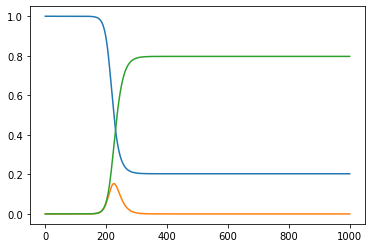

In [57]:
naive_world = Population(7000000000)
NaiveSIRModel=SIRModel(naive_world,0.2,0.1)
NaiveSIRModel.runInfectionSimulation(1000,0.01,1/naive_world.pop_size)
plt.plot(NaiveSIRModel.t_history,NaiveSIRModel.state_history)
plt.show()

{'beta': 0.4601432708428594, 'gamma': 0.14458161865569275}


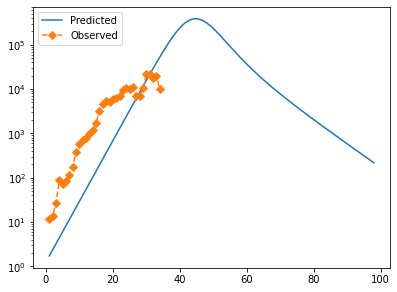

In [60]:
populations=loadPopulations("CaseData")
optimal_parameters=iterativeOptimization(checkModelFitPopulations, \
                                         4,\
                                         model=SIRModel, \
                                         populations=populations, \
                                         resolution=0.01, \
                                         errorFunction=percentAbsErrorSevenCenteredAverage, \
                                         Vbeta=(0,1,10), \
                                         Vgamma=(0,0.2,10)) 
pop_model=None
print(optimal_parameters)
for population in populations:
    
    pop_model=SIRModel(population,**optimal_parameters)
    pop_model.runInfectionSimulation(100,0.01,pop_model.population.getInfectionData()[0]/pop_model.population.pop_size)
    pop_model.graphCases()


{'beta': 1.9347660417619277, 'gamma': 1.141289437585734, 'alpha': 8.562277091906727}


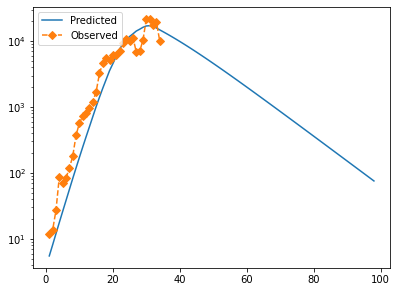

In [63]:
populations=loadPopulations("CaseData")
optimal_parameters=iterativeOptimization(checkModelFitPopulations, \
                                         4,\
                                         model=SEIRVBModel, \
                                         populations=populations, \
                                         resolution=0.1, \
                                         errorFunction=percentAbsErrorSevenCenteredAverage, \
                                         Vbeta=(0,2,10), \
                                         Vgamma=(0,1,10), \
                                         Valpha=(0.1,20,10), \
                                         vax_effect=0.25, \
                                         boost_effect=0.7) 
pop_model=None
print(optimal_parameters)
for population in populations:
    pop_model=SEIRVBModel(population,vax_effect=0.25,boost_effect=0.7,**optimal_parameters)
    pop_model.runInfectionSimulation(100,0.01,pop_model.population.getInfectionData()[0]/pop_model.population.pop_size)
    pop_model.graphCases()


In [57]:
%prun iterativeOptimization(checkModelFitPopulations, \
                                         4,\
                                         model=SEIRVBModel, \
                                         populations=populations, \
                                         resolution=0.1, \
                                         errorFunction=percentAbsErrorSevenCenteredAverage, \
                                         Vbeta=(0,2,10), \
                                         Vgamma=(0,0.2,10), \
                                         Valpha=(0.1,10,10), \
                                         vax_effect=0.25, \
                                         boost_effect=0.7) 

         191496963 function calls in 149.241 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  5713400   47.371    0.000  120.657    0.000 688635787.py:139(updateModel)
 17140200   26.330    0.000   43.818    0.000 688635787.py:33(getHealthData)
 28583324   23.201    0.000   23.201    0.000 {built-in method builtins.min}
  5713400   11.183    0.000   30.459    0.000 688635787.py:45(getNewShots)
    16324    8.131    0.000  138.490    0.008 688635787.py:61(runInfectionSimulation)
 58848020    6.548    0.000    6.548    0.000 {method 'get' of 'dict' objects}
  7949788    4.985    0.000    4.985    0.000 {built-in method builtins.round}
  1110032    4.464    0.000    4.464    0.000 {method 'index' of 'list' objects}
  5713400    3.503    0.000    4.385    0.000 688635787.py:171(recordState)
 28599648    3.097    0.000    3.097    0.000 {method 'keys' of 'dict' objects}
 12553156    1.667    0.000    1.667    0.000 {method 'app